In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [56]:
# Step1:Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')


In [57]:
#Step 2: loading Data
def load_and_clean_data(filepath):
    """
    Loads a CSV file, parses 'Date', converts 'Price' to numeric,
    removes rows with missing values, and returns a clean DataFrame
    indexed by datetime.
    """
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
    df = df.dropna(subset=['Date', 'Price'])
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)
    return df

# Usage
file_path = "/content/drive/MyDrive/oil_price.csv"
df = load_and_clean_data(file_path)


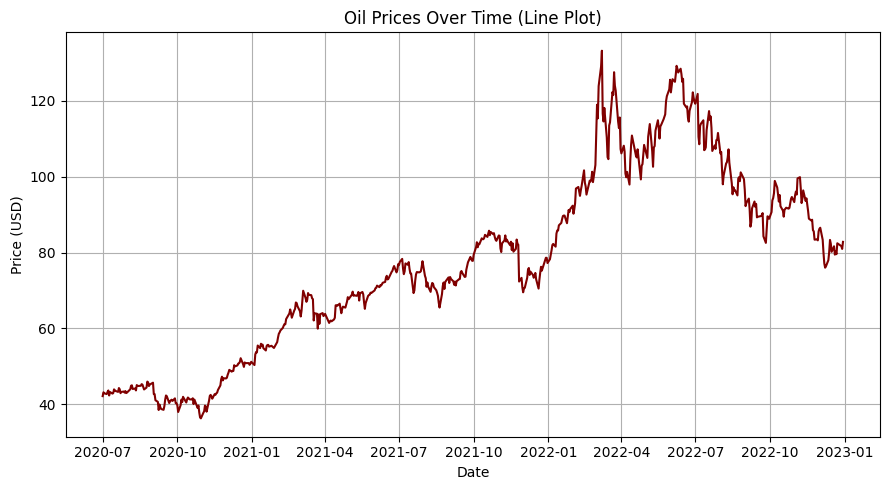

In [58]:
# STEP 3: EDA Plots for Oil Price Time Series
# 1.Line Plot
# 2.Histogram with KDE
# 3.Box Plot
def plot_line(df):
    """
    Plot a line chart showing oil prices over time.

    Parameters:
    df (DataFrame): DataFrame with a datetime index and 'Price' column.
    """
    plt.figure(figsize=(9, 5))
    plt.plot(df.index, df['Price'], color='maroon')
    plt.title('Oil Prices Over Time (Line Plot)')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_line(df)

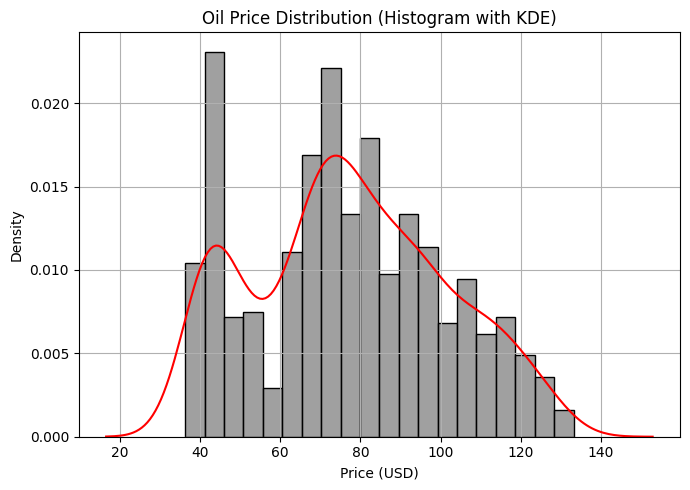

In [59]:
import seaborn as sns

def plot_histogram(df):
    """
    Plot a histogram of oil prices with a KDE line.
    """
    fig, ax = plt.subplots(figsize=(7, 5))

    # Histogram (density so it’s on the same scale as the KDE)
    sns.histplot(df['Price'],
                 bins=20,
                 stat='density',
                 color='grey',
                 ax=ax)

    # KDE line in red
    sns.kdeplot(df['Price'],
                color='red',
                ax=ax)

    ax.set_title("Oil Price Distribution (Histogram with KDE)")
    ax.set_xlabel("Price (USD)")
    ax.set_ylabel("Density")
    ax.grid(True)
    plt.tight_layout()
    plt.show()

plot_histogram(df)

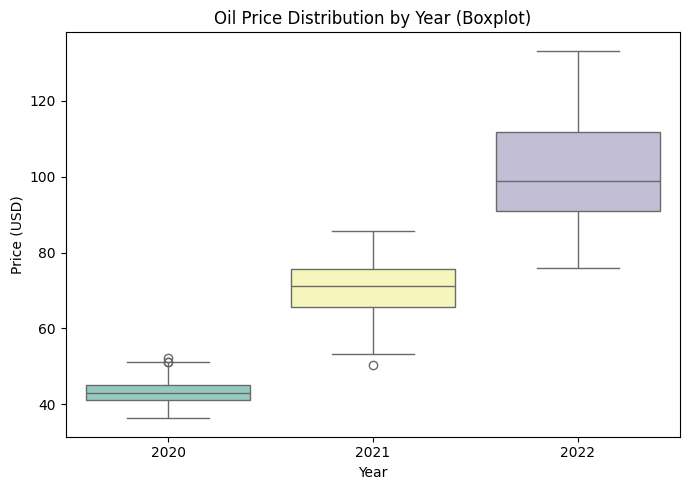

In [60]:
def plot_boxplot(df):
    """
    Plot a boxplot to show the distribution of oil prices by year.

    Parameters:
    df (DataFrame): DataFrame with a datetime index and 'Price' column.
                   The function extracts 'Year' from the index.
    """
    df_box = df.copy()
    df_box['Year'] = df_box.index.year

    plt.figure(figsize=(7, 5))
    sns.boxplot(x='Year', y='Price', data=df_box, palette='Set3')
    plt.title("Oil Price Distribution by Year (Boxplot)")
    plt.xlabel("Year")
    plt.ylabel("Price (USD)")
    plt.tight_layout()
    plt.show()

plot_boxplot(df)

ADF Statistic: -1.598608589550151
p-value: 0.48429238915100054


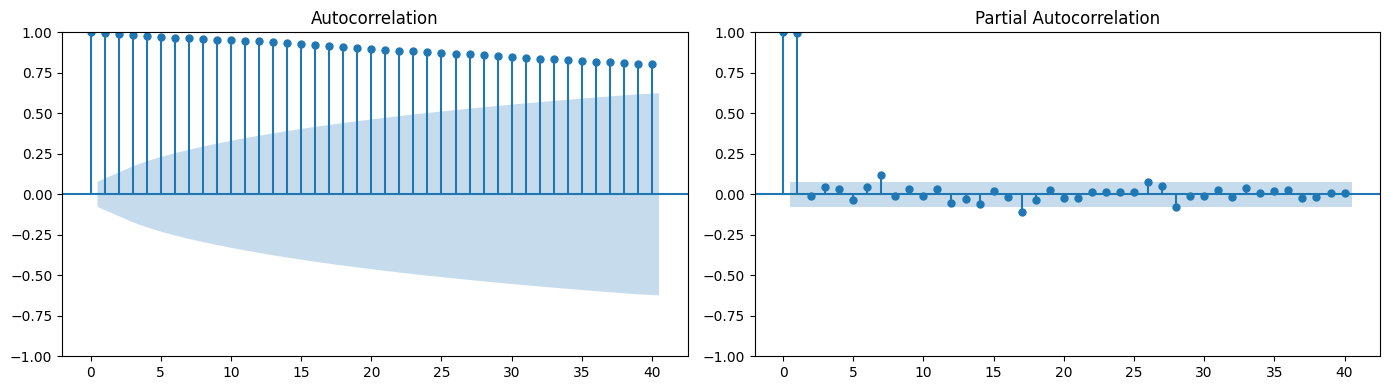

In [61]:
# Step 4: 4.1.Test for Stationarity using Augmented Dickey-Fuller Test
def test_stationarity(series):
    """
    Performs Augmented Dickey-Fuller test on a series.
    Returns the ADF statistic and p-value.
    """
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    return result[0], result[1]


# Apply to original series
test_stationarity(df['Price'])

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(df['Price'], ax=axes[0], lags=40)
plot_pacf(df['Price'], ax=axes[1], lags=40)
plt.tight_layout()
plt.show()


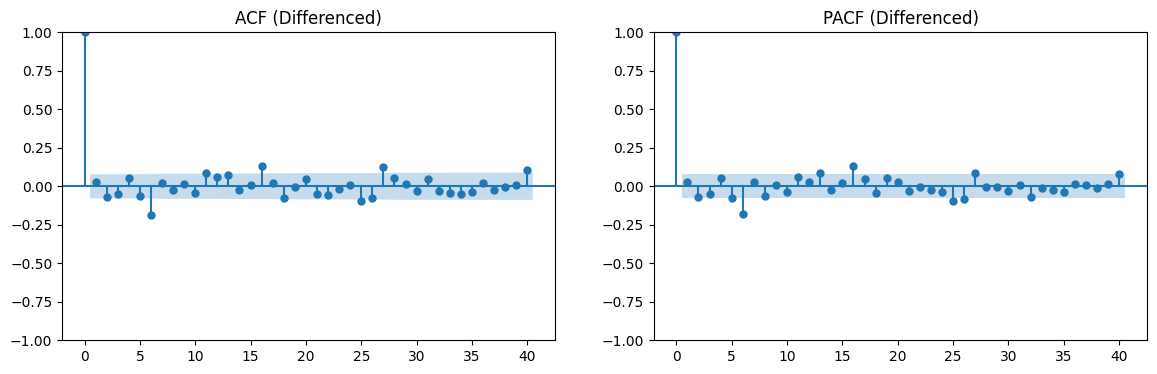

ADF Statistic: -5.278578124041285
p-value: 6.0637563460194175e-06


(np.float64(-5.278578124041285), np.float64(6.0637563460194175e-06))

In [62]:
#4.2. Differenced series
def difference_and_plot(df):
    """Applies differencing and shows ACF and PACF plots."""
    df['Price_diff'] = df['Price'].diff()
    df_diff = df.dropna()

    # Plot ACF and PACF
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    plot_acf(df_diff['Price_diff'], lags=40, ax=axes[0])
    plot_pacf(df_diff['Price_diff'], lags=40, ax=axes[1])
    axes[0].set_title("ACF (Differenced)")
    axes[1].set_title("PACF (Differenced)")
    plt.show()

    return df_diff

df_diff = difference_and_plot(df)
test_stationarity(df_diff['Price_diff'])


=== After First Differencing ===
ADF Statistic: -5.2786
p-value: 0.0000
Critical Value 1%: -3.4410
Critical Value 5%: -2.8662
Critical Value 10%: -2.5693


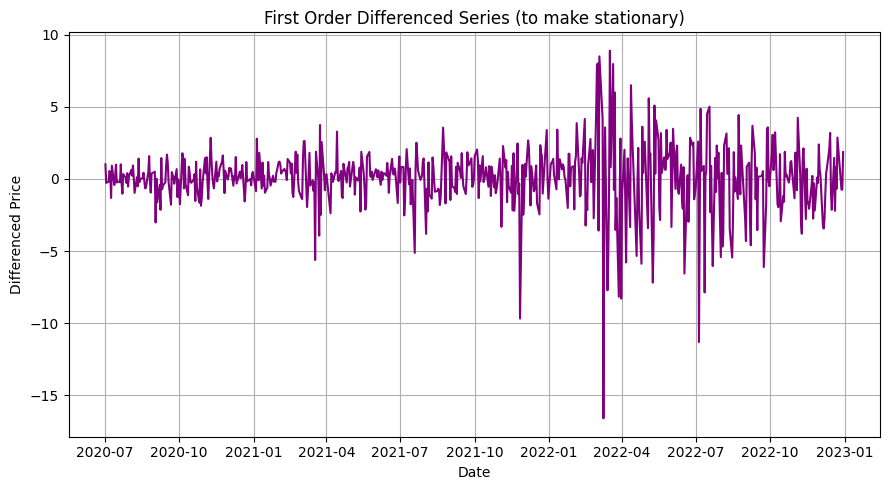

In [64]:
#Step 5: 5.1.Make the Series Stationary by Differencing and Re-Test Stationarity
def make_series_stationary(df):
    """
    Apply differencing to make the series stationary and re-test ADF.
    """
    # 1st order differencing
    df_diff = df['Price'].diff().dropna()

    # ADF test after differencing
    result = adfuller(df_diff)

    print("=== After First Differencing ===")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    for key, value in result[4].items():
        print(f"Critical Value {key}: {value:.4f}")

    # Plot the differenced series
    plt.figure(figsize=(9, 5))
    plt.plot(df_diff, color='purple')
    plt.title("First Order Differenced Series (to make stationary)")
    plt.xlabel("Date")
    plt.ylabel("Differenced Price")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return df_diff

# === Call the function ===
df_diff = make_series_stationary(df)


In [65]:
#5.2. finding best ARIMA Order
def select_arima_model(series, p_range=9, d=1, q_range=9):
    """Grid searches for best ARIMA(p,d,q) model using AIC."""
    best_aic = float("inf")
    best_order = None
    best_model = None

    for p in range(p_range):
        for q in range(q_range):
            try:
                model = ARIMA(series, order=(p, d, q)).fit()
                if model.aic < best_aic:
                    best_aic = model.aic
                    best_order = (p, d, q)
                    best_model = model
            except:
                continue

    print("Best ARIMA order:", best_order)
    print("AIC:", best_aic)
    return best_model, best_order

best_model, best_order = select_arima_model(df['Price'])


Best ARIMA order: (6, 1, 7)
AIC: 2808.3818624022247


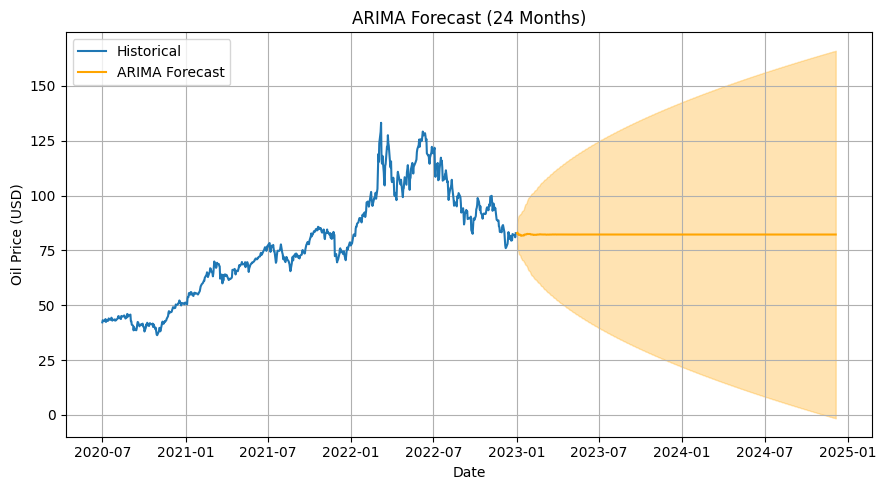

In [15]:
#Step 6: Forecast and Evaluation
def forecast_arima(model, df, steps=504):
    """Forecasts using ARIMA model for given steps into the future."""
    forecast_result = model.get_forecast(steps=steps)
    forecast_mean = forecast_result.predicted_mean
    forecast_ci = forecast_result.conf_int()
    forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=steps, freq='B')

    # Plot
    plt.figure(figsize=(9, 5))
    plt.plot(df.index, df['Price'], label='Historical')
    plt.plot(forecast_index, forecast_mean, label='ARIMA Forecast', color='orange')
    plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='orange', alpha=0.3)
    plt.title("ARIMA Forecast (24 Months)")
    plt.xlabel("Date")
    plt.ylabel("Oil Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return forecast_mean, forecast_index

forecast_mean, forecast_index = forecast_arima(best_model, df)


In [16]:
#ARIMA RMSE
def load_actual_data(filepath, start_date):
    """Loads and filters actual Brent prices starting after the forecast base date."""
    df = pd.read_csv(filepath, skiprows=2)
    df.columns = ['Date', 'Price']
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
    df = df.dropna()
    return df[df['Date'] > start_date].reset_index(drop=True)

actual_df = load_actual_data("/content/drive/MyDrive/RBRTEd.csv", df.index.max())

def calculate_rmse(predicted, actual):
    """Calculates RMSE between two aligned series."""
    return sqrt(mean_squared_error(actual, predicted[:len(actual)]))

rmse_arima = calculate_rmse(forecast_mean, actual_df['Price'])
print("ARIMA RMSE:", rmse_arima)


ARIMA RMSE: 11.02079406619239


In [67]:
#Comparison
# Find the minimum length between the forecast and actual data
min_len = min(len(forecast_index), len(actual_df))

comparison = pd.DataFrame({
    'Date': forecast_index[:min_len],
    'Forecast': forecast_mean[:min_len],
    'Actual': actual_df['Price'].values[:min_len]
})

rmse = np.sqrt(mean_squared_error(comparison['Actual'], comparison['Forecast']))
print("RMSE of Forecast:", rmse)
display(comparison.head())

RMSE of Forecast: 5.898082636154069


,Date,Forecast,Actual
635,2023-01-02,82.827770,80.36
636,2023-01-03,83.125467,75.31
637,2023-01-04,82.305592,76.73
638,2023-01-05,82.497504,76.41
639,2023-01-06,82.098011,77.50


In [68]:
#PART 2
from prophet import Prophet

DEBUG:cmdstanpy:input tempfile: /tmp/tmph8tn1cxa/lc5ro5lz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph8tn1cxa/6d1ujdcd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48233', 'data', 'file=/tmp/tmph8tn1cxa/lc5ro5lz.json', 'init=/tmp/tmph8tn1cxa/6d1ujdcd.json', 'output', 'file=/tmp/tmph8tn1cxa/prophet_modelptk0tdx2/prophet_model-20250707124454.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:44:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:44:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


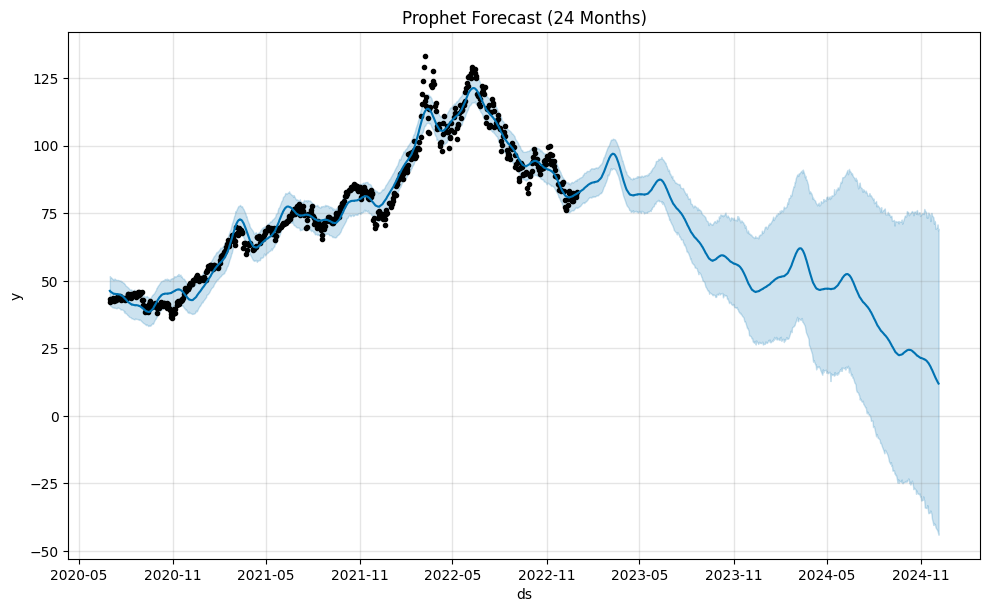


 Prophet RMSE: 32.376895154593065
Prophet RMSE: 32.376895154593065


,Date,Prophet Forecast,Actual
0,2023-01-03,82.611993,80.36
1,2023-01-04,82.715923,75.31
2,2023-01-05,82.831922,76.73
3,2023-01-06,82.872335,76.41
4,2023-01-09,83.127942,77.50


,Date,Prophet Forecast,Actual
0,2023-01-03,82.611993,80.36
1,2023-01-04,82.715923,75.31
2,2023-01-05,82.831922,76.73
3,2023-01-06,82.872335,76.41
4,2023-01-09,83.127942,77.50
...,...,...,...
499,2024-12-20,14.120711,73.19
500,2024-12-23,12.958514,72.12
501,2024-12-24,12.609349,73.50
502,2024-12-27,12.297121,73.77


In [70]:
#Part 2: Step 1: loading and printing the forecast of the Prophet
def forecast_with_prophet(df, actual_df):
    # Prepare data
    prophet_df = df.reset_index()[['Date', 'Price']].rename(columns={'Date': 'ds', 'Price': 'y'})

    # Model
    model = Prophet(daily_seasonality=True)
    model.fit(prophet_df)

    # Forecast
    future = model.make_future_dataframe(periods=504, freq='B')
    forecast = model.predict(future)

    # Plot
    model.plot(forecast)
    plt.title("Prophet Forecast (24 Months)")
    plt.grid(True)
    plt.show()

    # Evaluate
    forecast_future = forecast[forecast['ds'] > df.index.max()].reset_index(drop=True)
    rmse = calculate_rmse(forecast_future['yhat'], actual_df['Price'][:len(forecast_future)])
    print("\n Prophet RMSE:", rmse)

    # Extract relevant portion of the Prophet forecast
    forecast_df = forecast[['ds', 'yhat']].copy()
    forecast_df = forecast_df[forecast_df['ds'] > df.index.max()].reset_index(drop=True)

    # Align with actual data
    comparison_prophet = pd.DataFrame({
        'Date': actual_df['Date'][:len(forecast_df)],
        'Prophet Forecast': forecast_df['yhat'].values,
        'Actual': actual_df['Price'][:len(forecast_df)].values
    })

    # Display RMSE again
    rmse_prophet = np.sqrt(mean_squared_error(comparison_prophet['Actual'], comparison_prophet['Prophet Forecast']))
    print("Prophet RMSE:", rmse_prophet)

    display(comparison_prophet.head())

    return comparison_prophet
forecast_with_prophet(df, actual_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmph8tn1cxa/x1hvbl6o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph8tn1cxa/muypn7j_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30315', 'data', 'file=/tmp/tmph8tn1cxa/x1hvbl6o.json', 'init=/tmp/tmph8tn1cxa/muypn7j_.json', 'output', 'file=/tmp/tmph8tn1cxa/prophet_modeldfyn9j4j/prophet_model-20250707114047.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:40:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:40:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


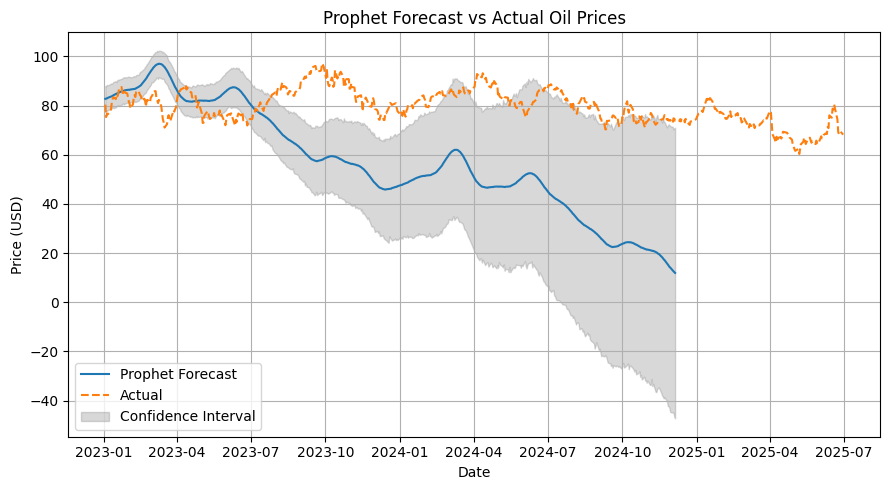

In [52]:
# Prophet Vs Actual oil Prices
def plot_prophet_forecast_vs_actual(oil_price_path: str, actual_price_path: str, forecast_days: int = 504) -> None:
    """
    Loads historical and actual oil price data, fits a Prophet model,
    forecasts future prices, and plots forecast vs actual with a grey confidence interval.

    Parameters:
        oil_price_path (str): Path to historical oil price CSV.
        actual_price_path (str): Path to actual Brent price CSV (skips 2 rows).
        forecast_days (int): Number of future business days to forecast. Default is 504.
    """
    # Load historical data
    df = pd.read_csv(oil_price_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
    df = df.dropna().sort_values('Date')
    df.set_index('Date', inplace=True)

    # Load actual data and clean
    actual_df = pd.read_csv(actual_price_path, skiprows=2, names=['Date', 'Price'])
    actual_df['Date'] = pd.to_datetime(actual_df['Date'], errors='coerce')
    actual_df['Price'] = pd.to_numeric(actual_df['Price'], errors='coerce')
    actual_df = actual_df.dropna()
    actual_df = actual_df[actual_df['Date'] > df.index.max()].reset_index(drop=True)

    # Prepare Prophet data
    prophet_df = df.reset_index().rename(columns={'Date': 'ds', 'Price': 'y'})

    # Fit Prophet model
    model = Prophet(daily_seasonality=True)
    model.fit(prophet_df)

    # Create future dataframe and forecast
    future = model.make_future_dataframe(periods=forecast_days, freq='B')
    forecast = model.predict(future)

    # Align forecast with actual data
    start_date = actual_df['Date'].min()
    end_date = actual_df['Date'].max()
    forecast_aligned = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)].reset_index(drop=True)
    actual_aligned = actual_df[(actual_df['Date'] >= start_date) & (actual_df['Date'] <= end_date)].reset_index(drop=True)

    # Plot forecast vs actual with confidence interval
    plt.figure(figsize=(9, 5))
    plt.plot(forecast_aligned['ds'], forecast_aligned['yhat'], label='Prophet Forecast')
    plt.plot(actual_aligned['Date'], actual_aligned['Price'], label='Actual', linestyle='dashed')
    plt.fill_between(
        forecast_aligned['ds'],
        forecast_aligned['yhat_lower'],
        forecast_aligned['yhat_upper'],
        color='grey',
        alpha=0.3,
        label='Confidence Interval'
    )
    plt.title('Prophet Forecast vs Actual Oil Prices')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


#Call the function
plot_prophet_forecast_vs_actual(
    oil_price_path='/content/drive/MyDrive/oil_price.csv',
    actual_price_path='/content/drive/MyDrive/RBRTEd.csv'
)
